In [12]:
from google.colab import drive
drive.mount('/content/drive')
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, log_loss

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<h1>Data Cleaning</h1>

In [13]:
df = pd.read_csv('/content/drive/MyDrive/maternal+health+risk/Maternal Health Risk Data Set.csv')
df.info()
df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1014 entries, 0 to 1013
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          1014 non-null   int64  
 1   SystolicBP   1014 non-null   int64  
 2   DiastolicBP  1014 non-null   int64  
 3   BS           1014 non-null   float64
 4   BodyTemp     1014 non-null   float64
 5   HeartRate    1014 non-null   int64  
 6   RiskLevel    1014 non-null   object 
dtypes: float64(2), int64(4), object(1)
memory usage: 55.6+ KB


,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
0,25,130,80,15.0,98.0,86,high risk
1,35,140,90,13.0,98.0,70,high risk
2,29,90,70,8.0,100.0,80,high risk
3,30,140,85,7.0,98.0,70,high risk
4,35,120,60,6.1,98.0,76,low risk
...,...,...,...,...,...,...,...
1009,22,120,60,15.0,98.0,80,high risk
1010,55,120,90,18.0,98.0,60,high risk
1011,35,85,60,19.0,98.0,86,high risk
1012,43,120,90,18.0,98.0,70,high risk


Check fo null values

In [14]:
df.isnull().sum()

# Count of NaN values in each column
nan_counts = df.isnull().sum()

# Filter columns with at least one NaN value
columns_with_nan = nan_counts[nan_counts > 0].index.tolist()

if len(columns_with_nan) == 0:
  print("no column with NAN values")
else:
  print(columns_with_nan)

no column with NAN values


Remove duplicates

In [15]:
df = df.drop_duplicates(ignore_index=True)
df

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
0,25,130,80,15.0,98.0,86,high risk
1,35,140,90,13.0,98.0,70,high risk
2,29,90,70,8.0,100.0,80,high risk
3,30,140,85,7.0,98.0,70,high risk
4,35,120,60,6.1,98.0,76,low risk
...,...,...,...,...,...,...,...
447,12,100,50,6.4,98.0,70,mid risk
448,15,100,60,6.0,98.0,80,low risk
449,15,100,49,7.6,98.0,77,low risk
450,12,100,50,6.0,98.0,70,mid risk


Outlier detection


In [16]:
df_numerical = df.drop(columns=['RiskLevel'])
data_types = df_numerical.dtypes
print(data_types)
df_numerical = df_numerical[(np.abs(stats.zscore(df_numerical)) < 3).all(axis=1)]
df_numerical

Age              int64
SystolicBP       int64
DiastolicBP      int64
BS             float64
BodyTemp       float64
HeartRate        int64
dtype: object


,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate
0,25,130,80,15.0,98.0,86
1,35,140,90,13.0,98.0,70
2,29,90,70,8.0,100.0,80
3,30,140,85,7.0,98.0,70
4,35,120,60,6.1,98.0,76
...,...,...,...,...,...,...
447,12,100,50,6.4,98.0,70
448,15,100,60,6.0,98.0,80
449,15,100,49,7.6,98.0,77
450,12,100,50,6.0,98.0,70


Standardize the data

In [17]:
scaler = StandardScaler()
df_scaled_array = scaler.fit_transform(df_numerical)
df_scaled = pd.DataFrame(df_scaled_array, columns=df_numerical.columns)
df_scaled

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate
0,-0.277878,1.149703,0.368914,3.135495,-0.479245,1.602005
1,0.458188,1.723546,1.104674,2.235886,-0.479245,-0.549961
2,0.016549,-1.145671,-0.366846,-0.013136,1.065190,0.795018
3,0.090155,1.723546,0.736794,-0.462940,-0.479245,-0.549961
4,0.458188,0.575859,-1.102606,-0.867764,-0.479245,0.257026
...,...,...,...,...,...,...
422,-1.234763,-0.571828,-1.838366,-0.732823,-0.479245,-0.549961
423,-1.013944,-0.571828,-1.102606,-0.912745,-0.479245,0.795018
424,-1.013944,-0.571828,-1.911942,-0.193058,-0.479245,0.391524
425,-1.234763,-0.571828,-1.838366,-0.912745,-0.479245,-0.549961



<h1>Feature Importance</h1>

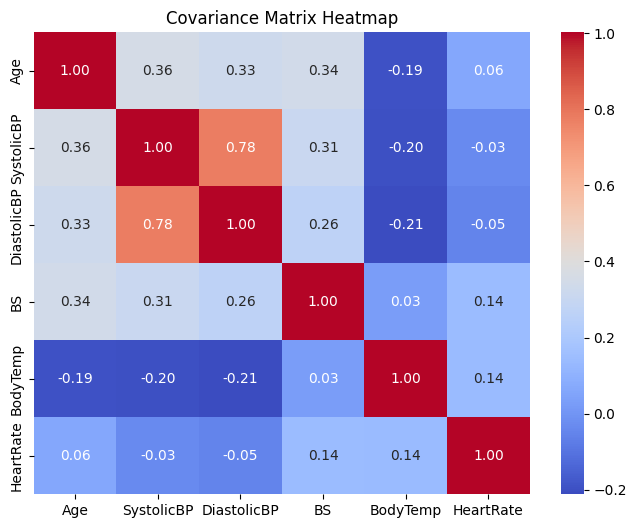

In [18]:
cov_matrix = df_scaled.cov()
plt.figure(figsize=(8, 6))
sns.heatmap(cov_matrix, annot=True, fmt='.2f', cmap='coolwarm', cbar=True)
plt.title('Covariance Matrix Heatmap')
plt.show()

Feature selection using random forest classifier

In [19]:
# Assuming target is your label column
X = df.drop('RiskLevel', axis=1)  # Independent variables
y = df['RiskLevel']  # Dependent variable

clf = RandomForestClassifier(n_estimators=100)
clf.fit(X, y)

selector = SelectFromModel(clf, threshold="mean")
selector.fit(X, y)

selected_features = X.columns[selector.get_support(indices=True)]
df = df[selected_features]
print(df)


     SystolicBP    BS
0           130  15.0
1           140  13.0
2            90   8.0
3           140   7.0
4           120   6.1
..          ...   ...
447         100   6.4
448         100   6.0
449         100   7.6
450         100   6.0
451         100   6.8

[452 rows x 2 columns]


Feature selection using lasso regularization

Total number of duplicates: 562
Number of rows in the cleaned dataset: 866
Linear Regression Coefficients:
Age            0.006546
SystolicBP     0.218350
DiastolicBP    0.031356
BS             0.343462
BodyTemp       0.216369
HeartRate      0.084847
dtype: float64


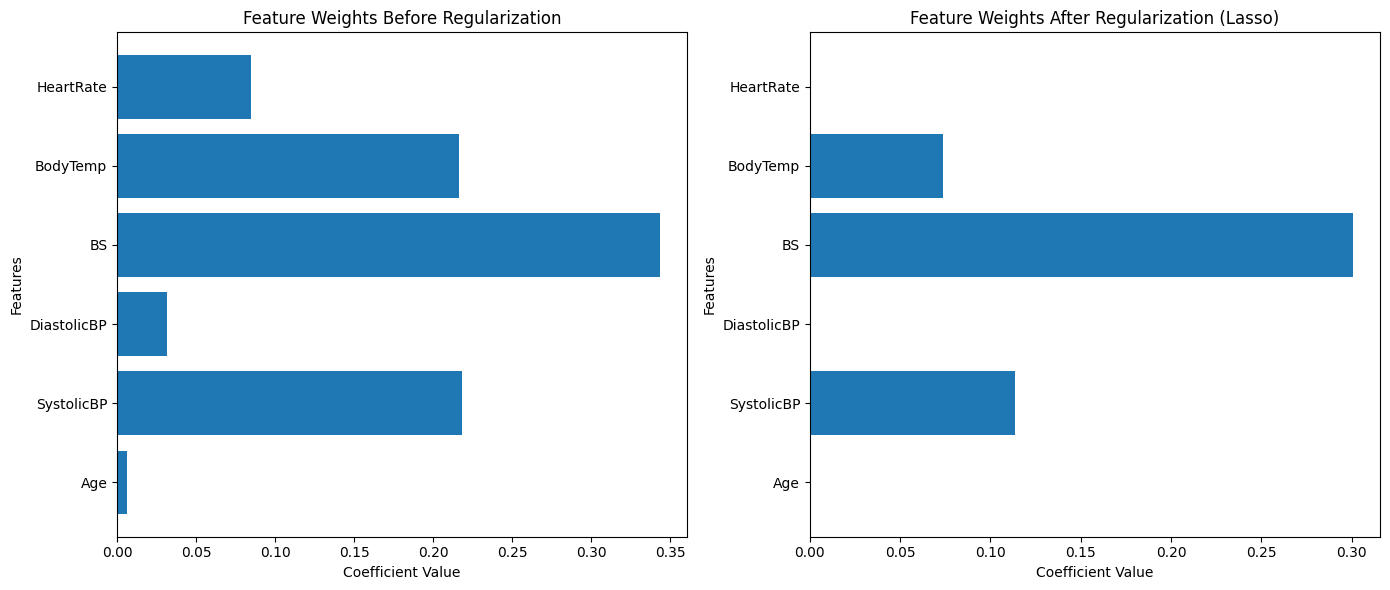

In [20]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.preprocessing import StandardScaler

# Load the cleaned dataset
df = pd.read_csv('/content/drive/MyDrive/maternal+health+risk/Maternal Health Risk Data Set.csv')

#Dropping the duplicates
print(f"Total number of duplicates: {df.duplicated().sum()}")
df_cleaned = df.loc[df.duplicated(keep=False)].sort_values(by=df.columns.to_list())

# Print the number of rows in the cleaned dataset
print(f"Number of rows in the cleaned dataset: {df_cleaned.shape[0]}")

# Mapping RiskLevel to numeric values
risk_mapping = {'low risk': 0, 'mid risk': 1, 'high risk': 2}
df_cleaned['RiskLevel'] = df_cleaned['RiskLevel'].map(risk_mapping)

# Handling any potential typos in the RiskLevel column
df_cleaned = df_cleaned.dropna(subset=['RiskLevel'])

# Features and target variable
X = df_cleaned.drop(columns='RiskLevel')
y = df_cleaned['RiskLevel']

# Standardizing the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Fit Linear Regression model (before regularization)
linear_model = LinearRegression()
linear_model.fit(X_scaled, y)
linear_coefficients = pd.Series(linear_model.coef_, index=X.columns)

# Apply Lasso Regression (after regularization)
lasso = Lasso(alpha=0.1)  # Alpha is the regularization strength
lasso.fit(X_scaled, y)
lasso_coefficients = pd.Series(lasso.coef_, index=X.columns)

# Plotting the coefficients before and after regularization
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Before regularization
ax[0].barh(X.columns, linear_coefficients)
ax[0].set_title('Feature Weights Before Regularization')
ax[0].set_xlabel('Coefficient Value')
ax[0].set_ylabel('Features')

# After regularization
ax[1].barh(X.columns, lasso_coefficients)
ax[1].set_title('Feature Weights After Regularization (Lasso)')
ax[1].set_xlabel('Coefficient Value')
ax[1].set_ylabel('Features')

# Print the coefficients to inspect the differences
print("Linear Regression Coefficients:")
print(linear_coefficients)

plt.tight_layout()
plt.show()
